<a href="https://colab.research.google.com/github/Igorps023/Amazon-Products-Review/blob/main/ETL_Spark_SQL_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ETL e Análise Exploratória de Avaliação de Produtos

O objetivo principal deste projeto é apontar quais marcas de instrumentos musicais, possuem melhor avaliação.


*   As avaliações podem ser medidas de 5 (nota máxima) até 1 (nota mínima).
*   Dados foram coletados via API do Kaggle em formato JSON.
*   Dataset disponível em: https://www.kaggle.com/datasets/eswarchandt/amazon-music-reviews
*   Para este projeto, foi utilizado PySpark, SQL e Pandas.

# Sobre os dados do dataset (colunas)
*   
reviewerID - ID do revisor, ex: A2SUAM1J3GNN3B
*   
asin - ID do produto, ex: 0000013714
*   
reviewerName - nome do revisor
*   
helpful - classificação de ajuda da análise, ex: 2/3
*   
reviewText - texto da análise
*   
overall - classificação do produto
*   
summary - resumo da análise
*   
unixReviewTime - tempo da análise (tempo Unix)
*   
reviewTime - tempo da análise (original)

# Workflow

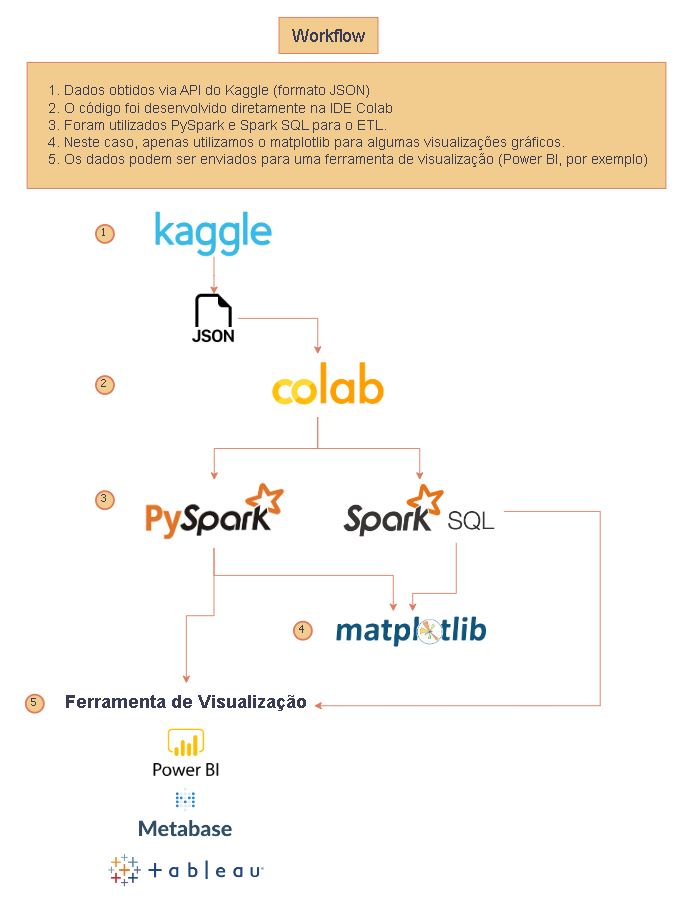

# Principais Informações do Dataset

# Volume de Avaliações (mês a mês)

A partir de 2011, há um crescimento significativo no número de avaliações (possivelmente decorrente do maior número de vendas, ao longo da série)

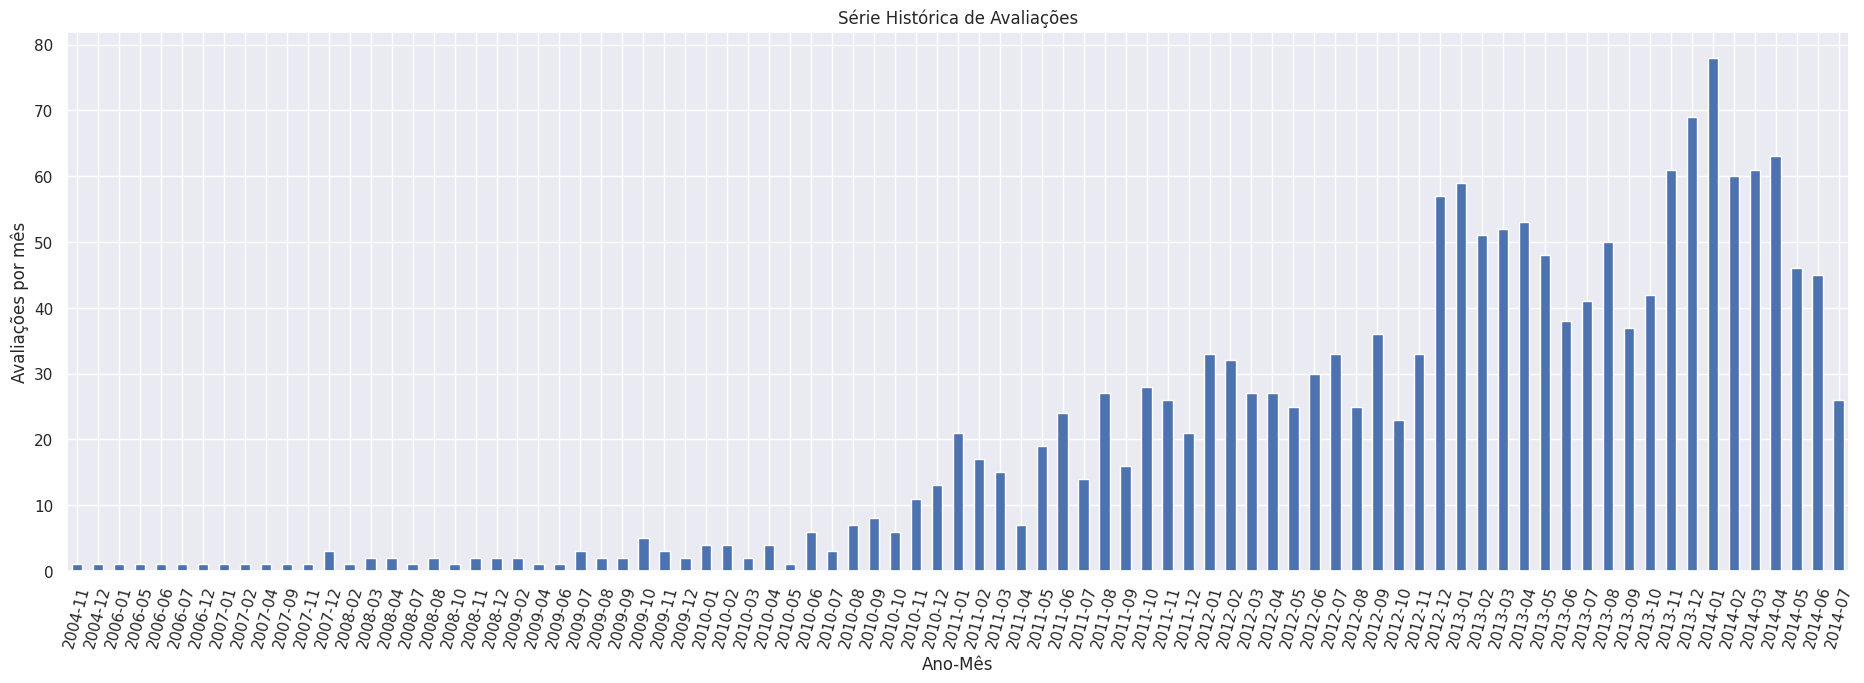

# Volume de Avaliações  (Agrupado por Marca e Nota)

Podemos perceber que as marcas Fender e ESP foram mencionadas em grande parte das avaliações.

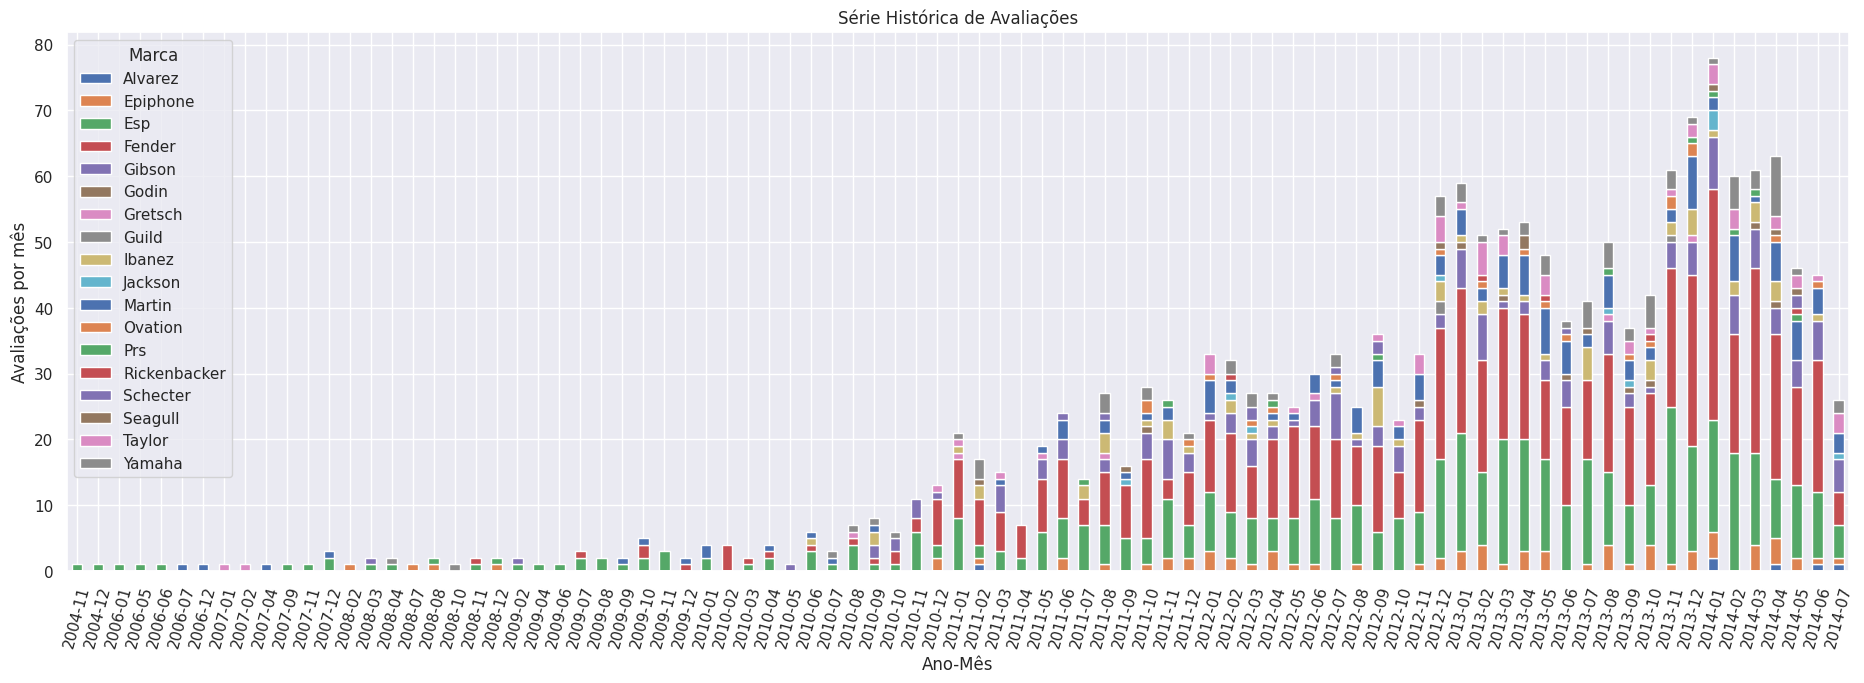

# Avaliações por Nota

A maioria das avaliações contempla a nota máxima.

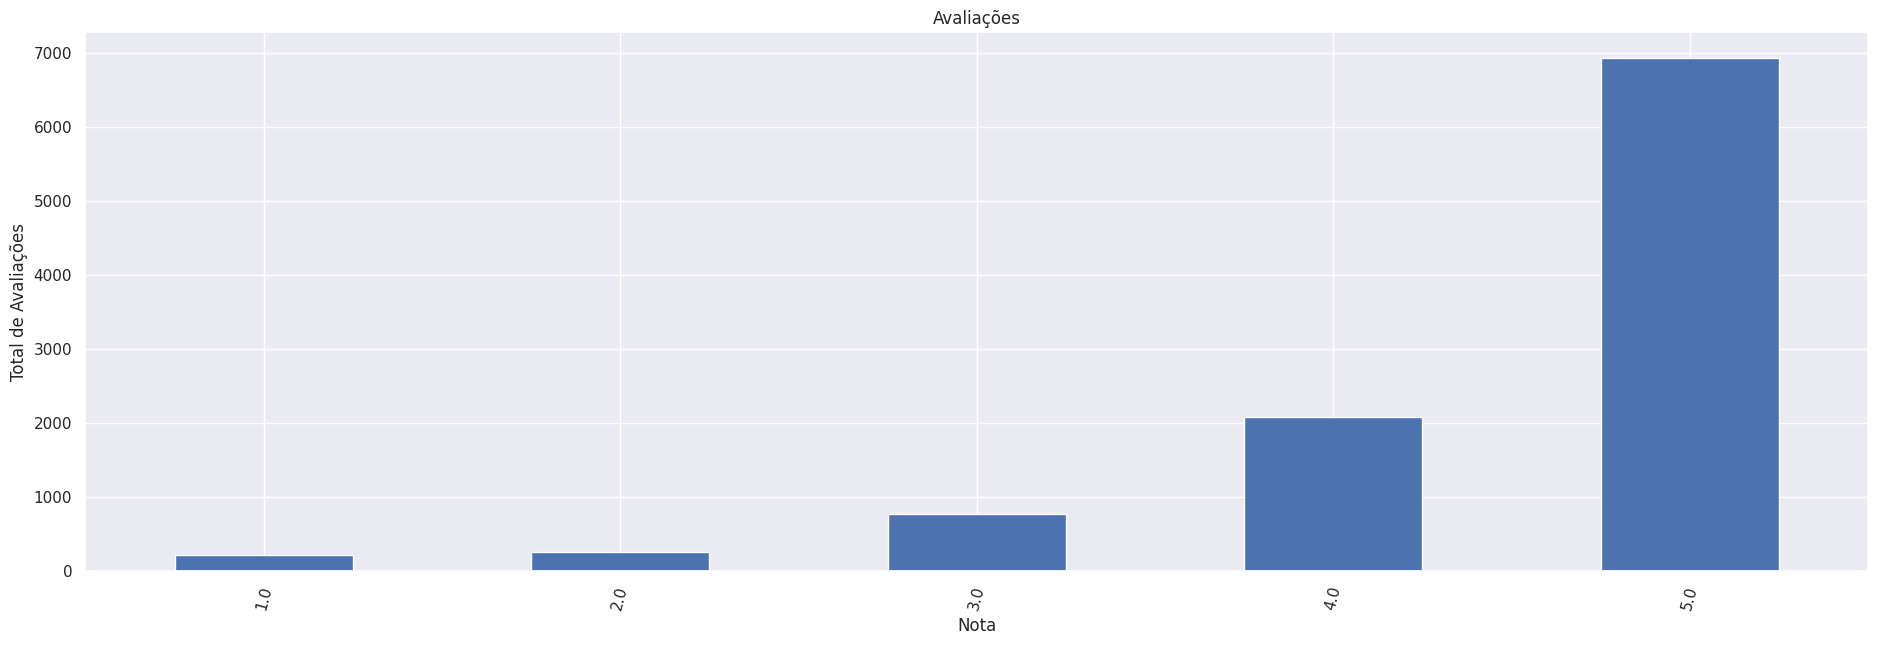

# Avaliações por Nota e Marca

O mesmo comportamento descrito anteriormente, é refletido para as Marcas Fender e ESP:

* Nota 4, ESP apresentou mais avaliações positivas que Fender.
* Nota 5, Fender obteve mais avaliações, e a diferença em relação a ESP é maior.



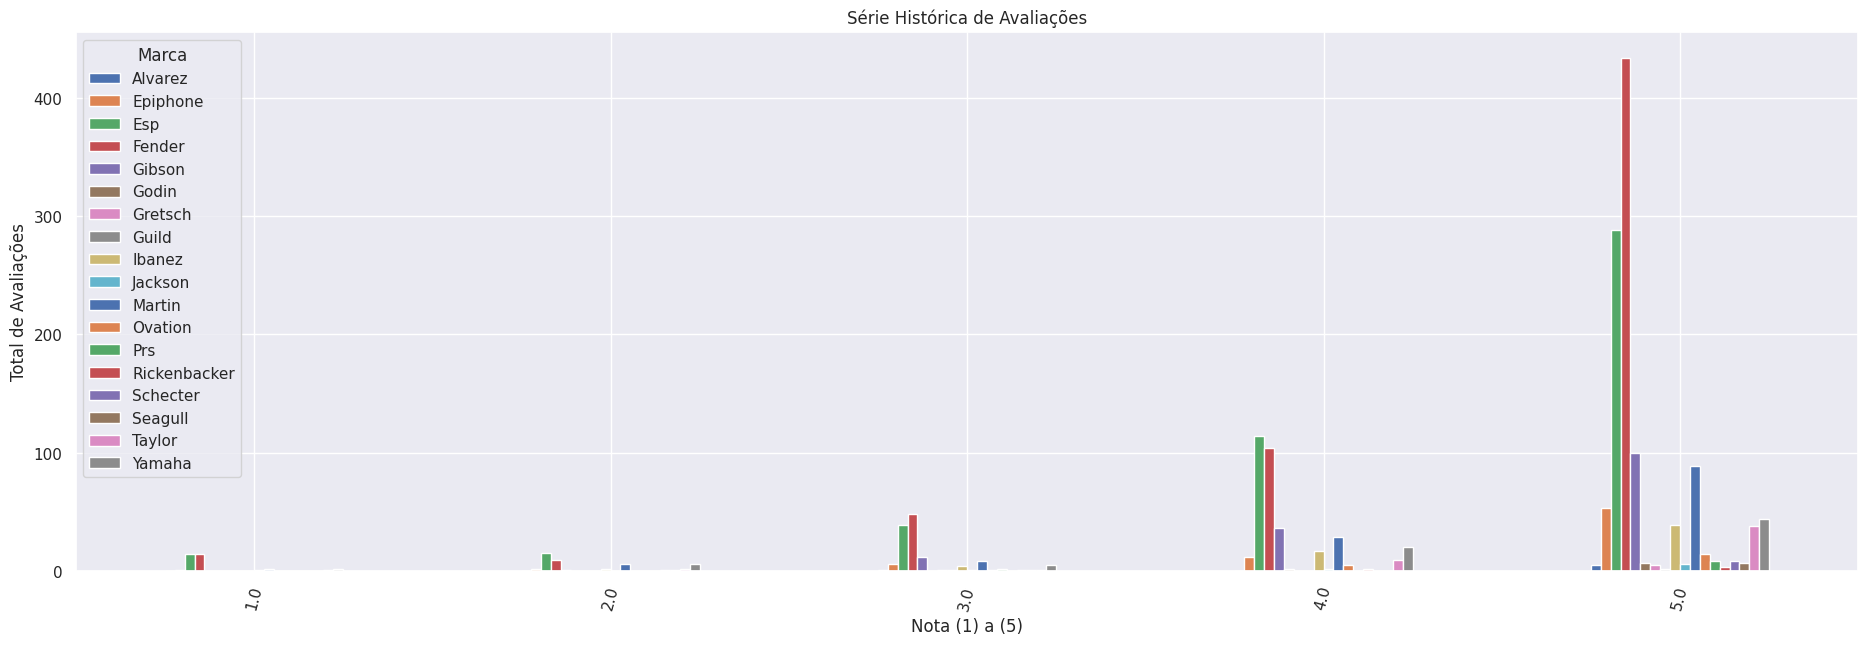

# Nuvem de Palavras: Principais palavras mencionadas nos comentários com Nota 5

Para as avaliações nota 5, encontramos palavras como: Recommend, love, works, great. 

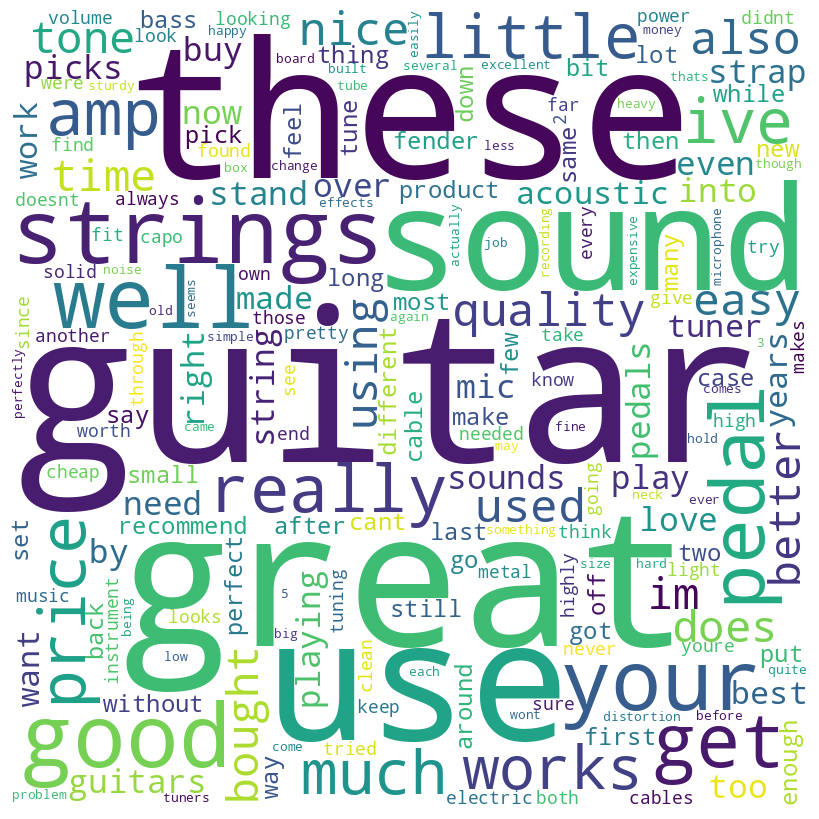

# Nuvem de Palavras: Principais palavras mencionadas nos comentários com Nota 1

Para as avaliações nota 1, encontramos palavras como: Useless, junk, cheap. 

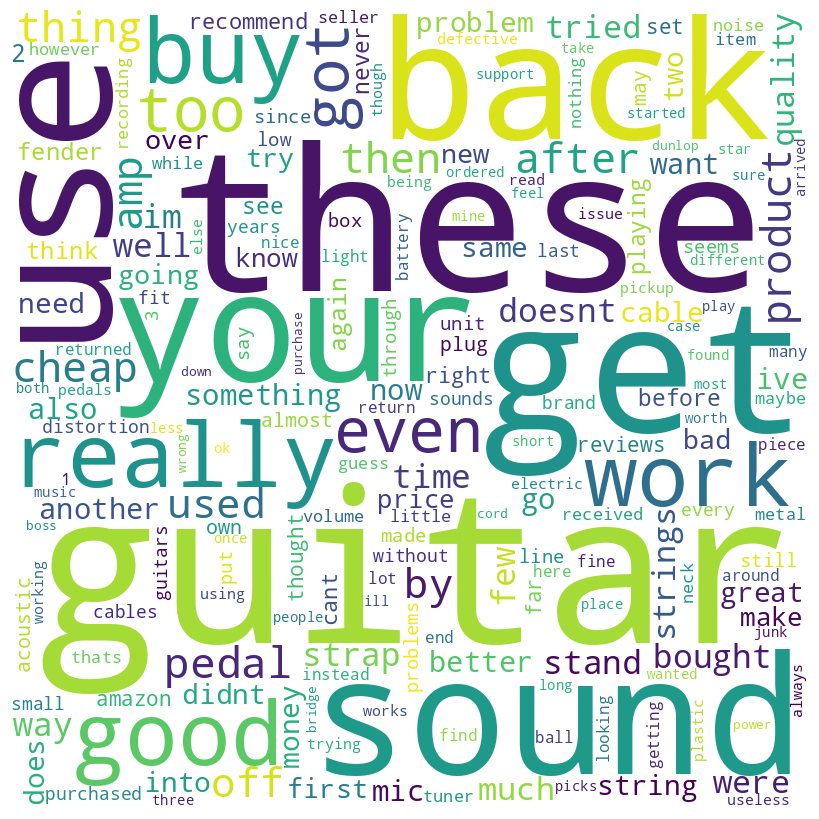

# Código

In [1]:
# Desmontar o Google Drive (se já estiver montado)
from google.colab import drive
drive.flush_and_unmount()

# Montar o Google Drive novamente
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# instalar as dependências
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.1//spark-3.3.1-bin-hadoop2.tgz
!tar xf spark-3.3.1-bin-hadoop2.tgz
!pip install -q findspark

In [3]:
# configurar as variáveis de ambiente
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop2.7"

In [4]:
#importando biblioteca para reconhecer o pyspark
import findspark
findspark.init('spark-3.3.1-bin-hadoop2')

In [5]:
#escrevendo um arquivo no nosso Drive para testar o mapeamento
with open('/content/drive/My Drive/Colab Notebooks/testando_mount.txt', 'w') as f:
    f.write('content')

In [6]:
#Criando nossa primeira Sessão com o SparkSession
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Aplicação Pyspark Amazon Review") \
    .config('spark.ui.port', '4050') \
    .getOrCreate()	

In [7]:
spark

In [8]:
#instalar extensão kaggle
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import json 
import os
from pathlib import Path

# your api key
api_key = {
'username':"your-username" ,
'key':"your-key"}

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object 
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)  

In [12]:
#importar biblioteca kaggle
import kaggle

In [13]:
#pathway até o dataset
kaggle.api.authenticate()
kaggle.api.dataset_download_files('eswarchandt/amazon-music-reviews', path='./data', unzip=True)

In [14]:
# ler o arquivo JSON baixado do Kaggle
dataset_raw = spark.read.json("./data/Musical_Instruments_5.json")

In [15]:
dataset_raw

DataFrame[asin: string, helpful: array<bigint>, overall: double, reviewText: string, reviewTime: string, reviewerID: string, reviewerName: string, summary: string, unixReviewTime: bigint]

In [16]:
#numero colunas e linhas
num_rows = dataset_raw.count()
num_cols = len(dataset_raw.columns)

In [17]:
print('Shape: ({}, {})'.format(num_rows, num_cols))

Shape: (10261, 9)


In [18]:
#colunas
dataset_raw.columns

['asin',
 'helpful',
 'overall',
 'reviewText',
 'reviewTime',
 'reviewerID',
 'reviewerName',
 'summary',
 'unixReviewTime']

In [19]:
#Tipo
type(dataset_raw)

pyspark.sql.dataframe.DataFrame

In [20]:
#Schema
dataset_raw.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [21]:
#Mostrar dataset
dataset_raw.show(truncate=True)

+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|      asin| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|1384719342|  [0, 0]|    5.0|Not much to write...|02 28, 2014|A2IBPI20UZIR0U|cassandra tu "Yea...|                good|    1393545600|
|1384719342|[13, 14]|    5.0|The product does ...|03 16, 2013|A14VAT5EAX3D9S|                Jake|                Jake|    1363392000|
|1384719342|  [1, 1]|    5.0|The primary job o...|08 28, 2013|A195EZSQDW3E21|Rick Bennette "Ri...|It Does The Job Well|    1377648000|
|1384719342|  [0, 0]|    5.0|Nice windscreen p...|02 14, 2014|A2C00NNG1ZQQG2|RustyBill "Sunday...|GOOD WINDSCREEN F...|    1392336000|
|1384719342|  [0, 0]|    5.0|This pop filter i...|02 21

In [22]:
#Para manipular colunas, utilizamos os métodos .withColumn() e .withColumnRenamed()
#col > função que retorna um objeto de coluna do Pyspark DataFrame.
#lit > função que retorna um objeto de coluna do Pyspark DataFrame com um valor literal.

#Importar bibliotecas

from pyspark.sql.functions import col, lit

In [23]:
#Renomear coluna

df_1 = dataset_raw.withColumnRenamed("asin","ProductID")

In [24]:
#Adicionar colunas temporais
from pyspark.sql.functions import from_unixtime, date_format

# Adicionar coluna com formato '%Y-%m-%d %H:%M:%S'
df_2_ = df_1.withColumn('reviewDateTime', from_unixtime('unixReviewTime', 'yyyy-MM-dd HH:mm:ss'))

# Adicionar coluna com formato '%Y-%m-%d'
df_2_ = df_2_.withColumn('reviewDate', date_format('reviewDateTime', 'yyyy-MM-dd'))

# Adicionar coluna com formato YYYY
df_2_ = df_2_.withColumn('reviewYear', date_format('reviewDateTime', 'yyyy'))

# Adicionar coluna com formato '%Y-%m'
df_1 = df_2_.withColumn('reviewMonth', date_format('reviewDateTime', 'yyyy-MM'))

df_1.show(5)

+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------------+----------+----------+-----------+
| ProductID| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|     reviewDateTime|reviewDate|reviewYear|reviewMonth|
+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------------+----------+----------+-----------+
|1384719342|  [0, 0]|    5.0|Not much to write...|02 28, 2014|A2IBPI20UZIR0U|cassandra tu "Yea...|                good|    1393545600|2014-02-28 00:00:00|2014-02-28|      2014|    2014-02|
|1384719342|[13, 14]|    5.0|The product does ...|03 16, 2013|A14VAT5EAX3D9S|                Jake|                Jake|    1363392000|2013-03-16 00:00:00|2013-03-16|      2013|    2013-03|
|1384719342|  [1, 1]|    5.0|The primary job o...|08 28

# Convertendo o dataframe para Parquet.

Após a conversão, todas as próximas etapas serão realizadas neste arquivo.

In [60]:
df_1.write.parquet("/content/drive/MyDrive/kaggle/Parquet-Files/Amazon-Project/parquet_df_1")

Leitura Parquet (Passamos o diretório até a pasta, quando um arquivo Parquet é gerado, automaticamente é criado uma abstração do dataframe que foi utilizado, onde separa-se em partições e metadados.

In [62]:
parquet_df_1 = spark.read.parquet("/content/drive/MyDrive/kaggle/Parquet-Files/Amazon-Project/parquet_df_1")

In [64]:
#Dataframe Spark
type(parquet_df_1)

pyspark.sql.dataframe.DataFrame

In [67]:
#numero colunas e linhas
num_rows = parquet_df_1.count()
num_cols = len(parquet_df_1.columns)

In [68]:
print('Shape: ({}, {})'.format(num_rows, num_cols))

Shape: (10261, 14)


In [69]:
#Ordenando dados

from pyspark.sql.functions import asc,desc

parquet_df_1.orderBy(desc("overall")).show(5)

+----------+-------+-------+--------------------+-----------+--------------+------------+--------------------+--------------+-------------------+----------+----------+-----------+-----+
| ProductID|helpful|overall|          reviewText| reviewTime|    reviewerID|reviewerName|             summary|unixReviewTime|     reviewDateTime|reviewDate|reviewYear|reviewMonth|Marca|
+----------+-------+-------+--------------------+-----------+--------------+------------+--------------------+--------------+-------------------+----------+----------+-----------+-----+
|B003VWKPHC| [1, 1]|    5.0|My mother "plays"...| 09 6, 2011|A202CZ4PJH83G4|     Tinfoot|Even my mother lo...|    1315267200|2011-09-06 00:00:00|2011-09-06|      2011|    2011-09|Outro|
|B003VWKPHC| [0, 0]|    5.0|This is the secon...|05 17, 2011|A3P2J1W1RBUX6Q|     Tommy B|         Works Great|    1305590400|2011-05-17 00:00:00|2011-05-17|      2011|    2011-05|Outro|
|B003VWKPHC| [0, 1]|    5.0|This is a very ve...|12 21, 2012|  AU2TEZY

# Método de classificação com Lambda

In [26]:
#Criando uma lista com os principais fabricantes de produtos e instrumentos musicais
#Esta lista será utilizada como Keyword dentro da coluna de comentários, ou seja, se o comentário conter estas palavras, a coluna Marca retorna como resposta a Marca para a linha correspondente

x = ["Gibson", "Fender", "Yamaha", "Martin", "Taylor", "Ibanez", "Gretsch", "PRS", "Epiphone", "Rickenbacker", "ESP", "Jackson", "Schecter", "Godin", "Seagull", "Guild", "Alvarez", "Ovation", "D'Angelico", "Ernie Ball Music Man"]

In [27]:
#Lista X em Minusculo
x = [i.lower() for i in x]
print(x)

['gibson', 'fender', 'yamaha', 'martin', 'taylor', 'ibanez', 'gretsch', 'prs', 'epiphone', 'rickenbacker', 'esp', 'jackson', 'schecter', 'godin', 'seagull', 'guild', 'alvarez', 'ovation', "d'angelico", 'ernie ball music man']


In [70]:
#Lambda Function
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import initcap

#Criando a função lambda para aplicar na coluna reviewText
classifica = udf(lambda text: next((i for i in x if i in text.lower()), "Outro"), StringType())

#Aplicando a função lambda na coluna reviewText e armazenando o resultado na nova coluna "marca"
parquet_df_1 = parquet_df_1.withColumn("Marca", initcap(classifica(parquet_df_1.reviewText)))

#Mostrando o resultado
parquet_df_1.show(5)

+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------------+----------+----------+-----------+-----+
| ProductID| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|     reviewDateTime|reviewDate|reviewYear|reviewMonth|Marca|
+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------------+----------+----------+-----------+-----+
|1384719342|  [0, 0]|    5.0|Not much to write...|02 28, 2014|A2IBPI20UZIR0U|cassandra tu "Yea...|                good|    1393545600|2014-02-28 00:00:00|2014-02-28|      2014|    2014-02|  Esp|
|1384719342|[13, 14]|    5.0|The product does ...|03 16, 2013|A14VAT5EAX3D9S|                Jake|                Jake|    1363392000|2013-03-16 00:00:00|2013-03-16|      2013|    2013-03|Outro|
|1384719342|  [1, 1]|    

# Views para consultas (SQL)

In [71]:
#Criando view Spark SQL
#df.createOrReplaceTempView(“df_view”)
parquet_df_1.createOrReplaceTempView("parquet_df_1")

In [72]:
spark.sql("""
SELECT *
FROM parquet_df_1
""").show()

+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------------+----------+----------+-----------+--------+
| ProductID| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|     reviewDateTime|reviewDate|reviewYear|reviewMonth|   Marca|
+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------------+----------+----------+-----------+--------+
|1384719342|  [0, 0]|    5.0|Not much to write...|02 28, 2014|A2IBPI20UZIR0U|cassandra tu "Yea...|                good|    1393545600|2014-02-28 00:00:00|2014-02-28|      2014|    2014-02|     Esp|
|1384719342|[13, 14]|    5.0|The product does ...|03 16, 2013|A14VAT5EAX3D9S|                Jake|                Jake|    1363392000|2013-03-16 00:00:00|2013-03-16|      2013|    2013-03|   Outro|
|138471934

In [73]:
#Distribuição de Notas em todo o dataset
#A maioria das avaliações está concentrada entre 5 e 4
spark.sql("""

SELECT COUNT(ProductID) AS Quantity,
      overall,
      Marca

FROM parquet_df_1
GROUP BY overall, Marca
ORDER BY overall DESC

""").show()

+--------+-------+------------+
|Quantity|overall|       Marca|
+--------+-------+------------+
|       8|    5.0|         Prs|
|       8|    5.0|    Schecter|
|      44|    5.0|      Yamaha|
|      39|    5.0|      Ibanez|
|      14|    5.0|     Ovation|
|     288|    5.0|         Esp|
|      38|    5.0|      Taylor|
|       5|    5.0|     Gretsch|
|       5|    5.0|     Alvarez|
|     434|    5.0|      Fender|
|       3|    5.0|Rickenbacker|
|    5788|    5.0|       Outro|
|       6|    5.0|     Jackson|
|       2|    5.0|       Guild|
|       7|    5.0|     Seagull|
|     100|    5.0|      Gibson|
|      89|    5.0|      Martin|
|       7|    5.0|       Godin|
|      53|    5.0|    Epiphone|
|    1732|    4.0|       Outro|
+--------+-------+------------+
only showing top 20 rows



In [74]:
#Distribuição de Notas em todo o dataset
#A maioria das avaliações está concentrada entre 5 e 4
df_all_outro = spark.sql("""

SELECT COUNT(ProductID) AS Quantity,
      overall,
      Marca

FROM parquet_df_1
GROUP BY overall, Marca
ORDER BY overall DESC

""")

In [75]:
#Distribuição de Notas em todo o dataset
#A maioria das avaliações está concentrada entre 5 e 4
df_all_sem_outro = spark.sql("""

SELECT COUNT(ProductID) AS Quantity,
      overall,
      Marca

FROM parquet_df_1
GROUP BY overall, Marca
HAVING MARCA <> 'Outro'
ORDER BY overall DESC

""")

In [76]:
parquet_df_1.columns

['ProductID',
 'helpful',
 'overall',
 'reviewText',
 'reviewTime',
 'reviewerID',
 'reviewerName',
 'summary',
 'unixReviewTime',
 'reviewDateTime',
 'reviewDate',
 'reviewYear',
 'reviewMonth',
 'Marca']

In [77]:
#Criando view Spark SQL
#df.createOrReplaceTempView(“df_view”)

#Podemos notar que mesmo após a análise, a maioria dos comentários não mencionaram diretamente as principais fabricantes no texto
 
parquet_df_1.createOrReplaceTempView("parquet_df_1_1")

spark.sql("""
SELECT Marca,
        COUNT(*) as QTD
 
FROM parquet_df_1
GROUP BY MARCA
ORDER BY QTD DESC
""").show(truncate=True)

+------------+----+
|       Marca| QTD|
+------------+----+
|       Outro|8547|
|      Fender| 609|
|         Esp| 470|
|      Gibson| 149|
|      Martin| 134|
|      Yamaha|  77|
|    Epiphone|  74|
|      Ibanez|  62|
|      Taylor|  51|
|     Ovation|  20|
|     Jackson|  10|
|         Prs|  10|
|    Schecter|  10|
|     Seagull|   9|
|       Godin|   9|
|     Gretsch|   6|
|     Alvarez|   6|
|Rickenbacker|   5|
|       Guild|   3|
+------------+----+



In [80]:
#Criando view Spark SQL
#df.createOrReplaceTempView(“df_view”)

#Podemos notar que mesmo após a análise, a maioria dos comentários não mencionaram diretamente as principais fabricantes no texto
 
parquet_df_1.createOrReplaceTempView("parquet_df_1_2")

spark.sql("""
SELECT Marca,
        COUNT(*) as QTD
 
FROM parquet_df_1
GROUP BY MARCA
HAVING UPPER(MARCA) <> UPPER('Outro')
ORDER BY QTD DESC
""").show

<bound method DataFrame.show of DataFrame[Marca: string, QTD: bigint]>

In [82]:
#Criando view Spark SQL
#df.createOrReplaceTempView(“df_view”)

#Podemos notar que mesmo após a análise, a maioria dos comentários não mencionaram diretamente as principais fabricantes no texto
 
parquet_df_1_2 = spark.sql("""
SELECT Marca,
        COUNT(*) as QTD
 
FROM parquet_df_1
GROUP BY MARCA
HAVING UPPER(MARCA) <> UPPER('Outro')
ORDER BY QTD DESC
""")

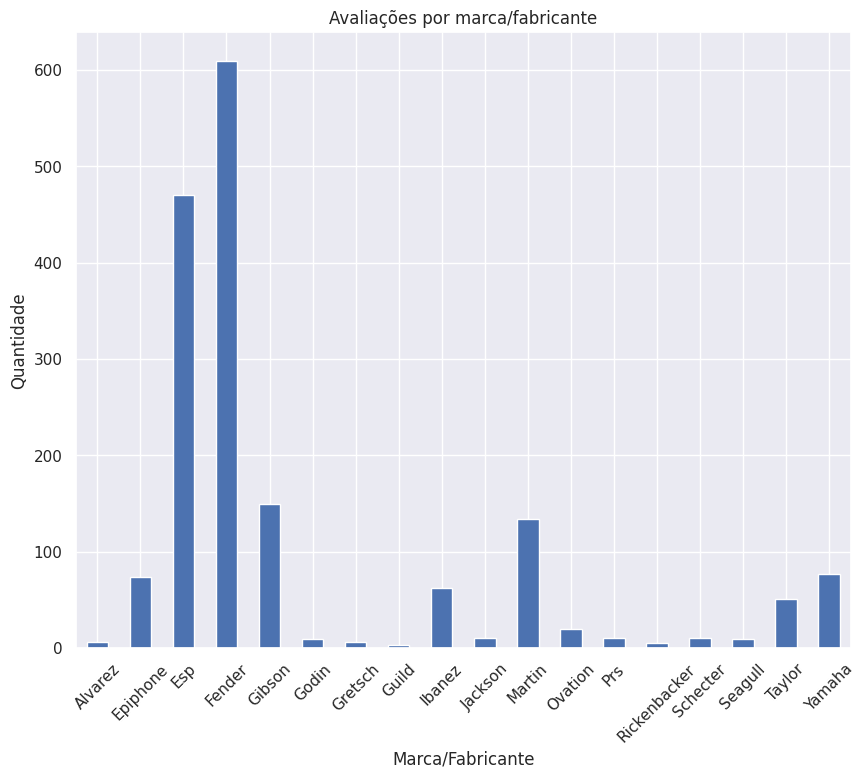

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Converter o merged_df para um dataframe do pandas
df_pandas = parquet_df_1_2.toPandas()

# agrupar por marca e contar a quantidade de avaliações
grouped_df = df_pandas.groupby('Marca')['QTD'].sum()

# gerar o gráfico de barras
grouped_df.plot(kind='bar', rot=45, figsize=(10,8), title='Avaliações por marca/fabricante')

# definir os rótulos dos eixos
plt.xlabel('Marca/Fabricante')
plt.ylabel('Quantidade')

# exibir o gráfico
plt.show()

In [39]:
df_1.createOrReplaceTempView("parquet_df_1_3")

spark.sql("""
SELECT Marca,
        overall,
        count(*) AS QTD

 
FROM parquet_df_1
GROUP BY MARCA, OVERALL
HAVING MARCA <> 'Outro'
ORDER BY MARCA ASC, OVERALL DESC, QTD DESC
""").show(10)

+--------+-------+---+
|   Marca|overall|QTD|
+--------+-------+---+
| Alvarez|    5.0|  5|
| Alvarez|    3.0|  1|
|Epiphone|    5.0| 53|
|Epiphone|    4.0| 12|
|Epiphone|    3.0|  6|
|Epiphone|    2.0|  2|
|Epiphone|    1.0|  1|
|     Esp|    5.0|288|
|     Esp|    4.0|114|
|     Esp|    3.0| 39|
+--------+-------+---+
only showing top 10 rows



In [84]:
#Criando view Spark SQL
#df.createOrReplaceTempView(“df_view”)

#Podemos notar que mesmo após a análise, a maioria dos comentários não mencionaram diretamente as principais fabricantes no texto
 
parquet_df_1_3 = spark.sql("""
SELECT Marca,
        overall,
        count(*) AS QTD

 
FROM parquet_df_1
GROUP BY MARCA, OVERALL
HAVING MARCA <> 'Outro'
ORDER BY MARCA ASC, OVERALL DESC, QTD DESC
""")

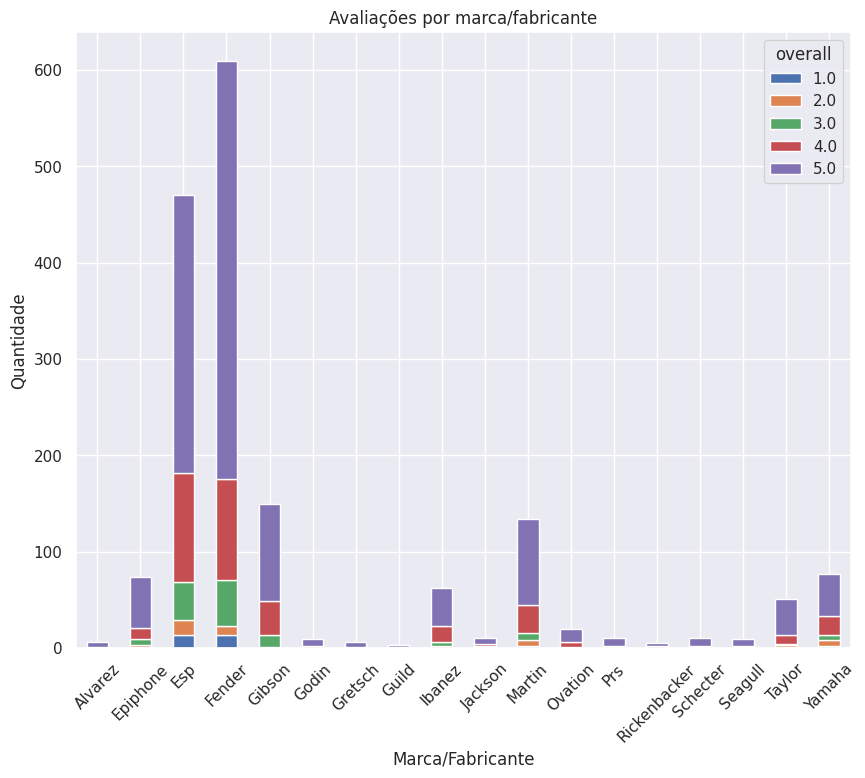

In [85]:
#Plotagem Gráfico
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Converter o grouped_df para um dataframe do pandas
df_pandas = parquet_df_1_3.toPandas()

# gerar o gráfico de barras empilhadas
df_pandas.pivot_table(index='Marca', columns='overall', values='QTD').plot(kind='bar', stacked=True, rot=45, figsize=(10,8), 
                title='Avaliações por marca/fabricante')

# definir os rótulos dos eixos
plt.xlabel('Marca/Fabricante')
plt.ylabel('Quantidade')


# exibir o gráfico
plt.show()


# Série Temporal

In [86]:
parquet_df_1.show(2)

+----------+--------+-------+--------------------+-----------+--------------+--------------------+-------+--------------+-------------------+----------+----------+-----------+-----+
| ProductID| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|summary|unixReviewTime|     reviewDateTime|reviewDate|reviewYear|reviewMonth|Marca|
+----------+--------+-------+--------------------+-----------+--------------+--------------------+-------+--------------+-------------------+----------+----------+-----------+-----+
|1384719342|  [0, 0]|    5.0|Not much to write...|02 28, 2014|A2IBPI20UZIR0U|cassandra tu "Yea...|   good|    1393545600|2014-02-28 00:00:00|2014-02-28|      2014|    2014-02|  Esp|
|1384719342|[13, 14]|    5.0|The product does ...|03 16, 2013|A14VAT5EAX3D9S|                Jake|   Jake|    1363392000|2013-03-16 00:00:00|2013-03-16|      2013|    2013-03|Outro|
+----------+--------+-------+--------------------+-----------+--------------+-------------

In [87]:
#Reviews em série temporal #ANO-MES
parquet_df_1.createOrReplaceTempView("parquet_df_1_4")

spark.sql("""
SELECT
      Marca,
      reviewMonth,
      COUNT(*) AS QTD_BY_MONTH
FROM parquet_df_1
WHERE Marca <> 'Outro'
GROUP BY reviewMonth, Marca
ORDER BY reviewMonth ASC, Marca ASC
""").show(10)

+------+-----------+------------+
| Marca|reviewMonth|QTD_BY_MONTH|
+------+-----------+------------+
|   Esp|    2004-11|           1|
|   Esp|    2004-12|           1|
|   Esp|    2006-01|           1|
|   Esp|    2006-05|           1|
|   Esp|    2006-06|           1|
|Martin|    2006-07|           1|
|Martin|    2006-12|           1|
|Taylor|    2007-01|           1|
|Taylor|    2007-02|           1|
|Martin|    2007-04|           1|
+------+-----------+------------+
only showing top 10 rows



In [88]:
parquet_df_1_5 = spark.sql("""
SELECT
      Marca,
      reviewMonth,
      COUNT(*) AS QTD_BY_MONTH
FROM parquet_df_1
WHERE Marca <> 'Outro'
GROUP BY reviewMonth, Marca
ORDER BY reviewMonth ASC, Marca ASC
""")

# Gráfico Temporal (Avaliações Mês a Mês) (Total)

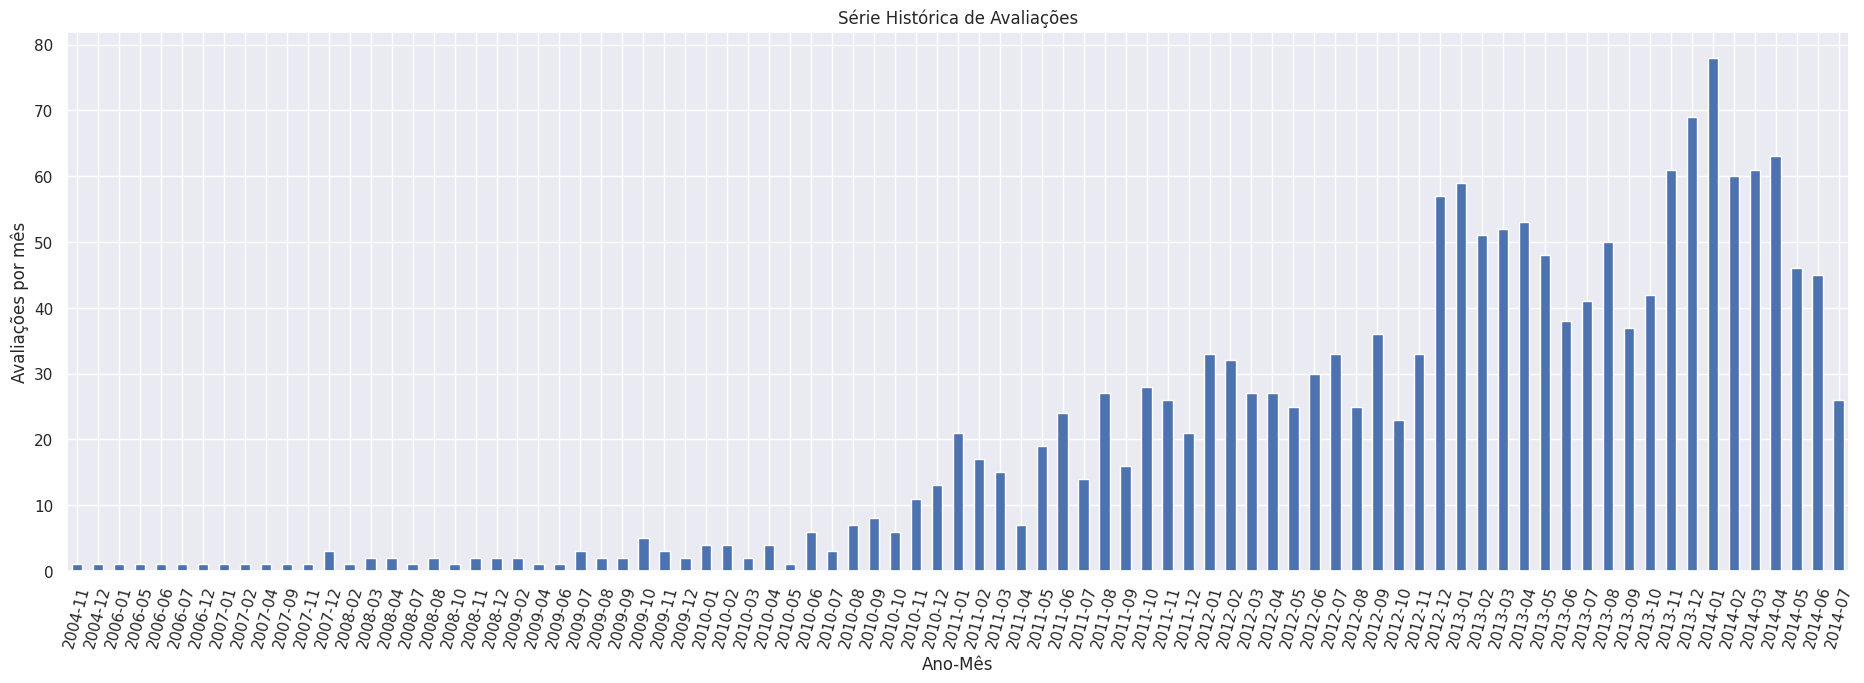

In [89]:
#Plotagem
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Converter o merged_df para um dataframe do pandas
df_pandas = parquet_df_1_5.toPandas()

# agrupar por marca e contar a quantidade de avaliações
grouped_df = df_pandas.groupby('reviewMonth')['QTD_BY_MONTH'].sum()

# gerar o gráfico de barras
grouped_df.plot(kind='bar', rot=75, figsize=(23,7), title='Série Histórica de Avaliações')

# definir os rótulos dos eixos
plt.xlabel('Ano-Mês')
plt.ylabel('Avaliações por mês')

# exibir o gráfico
plt.show()

# Gráfico Temporal (Avaliações Mês a Mês) por Fabricante/Marca

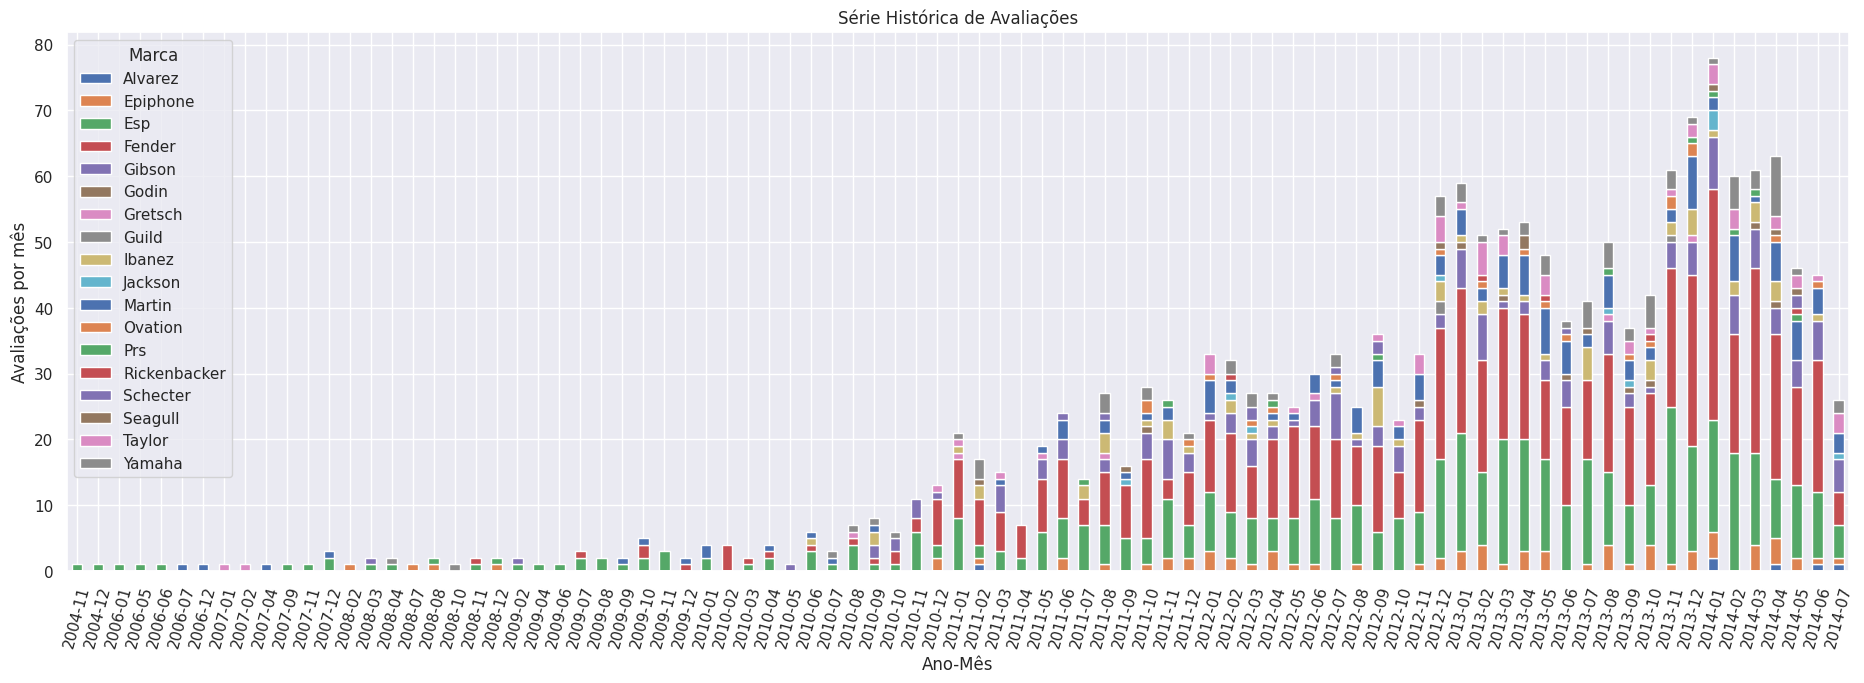

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Converter o merged_df para um dataframe do pandas
df_pandas = parquet_df_1_5.toPandas()

# agrupar por marca e contar a quantidade de avaliações
df_pandas.pivot_table(index='reviewMonth', columns='Marca', values='QTD_BY_MONTH').plot(kind='bar', stacked=True, rot=75, figsize=(23,7), 
                title='Série Histórica de Avaliações')

# definir os rótulos dos eixos
plt.xlabel('Ano-Mês')
plt.ylabel('Avaliações por mês')

# exibir o gráfico
plt.show()

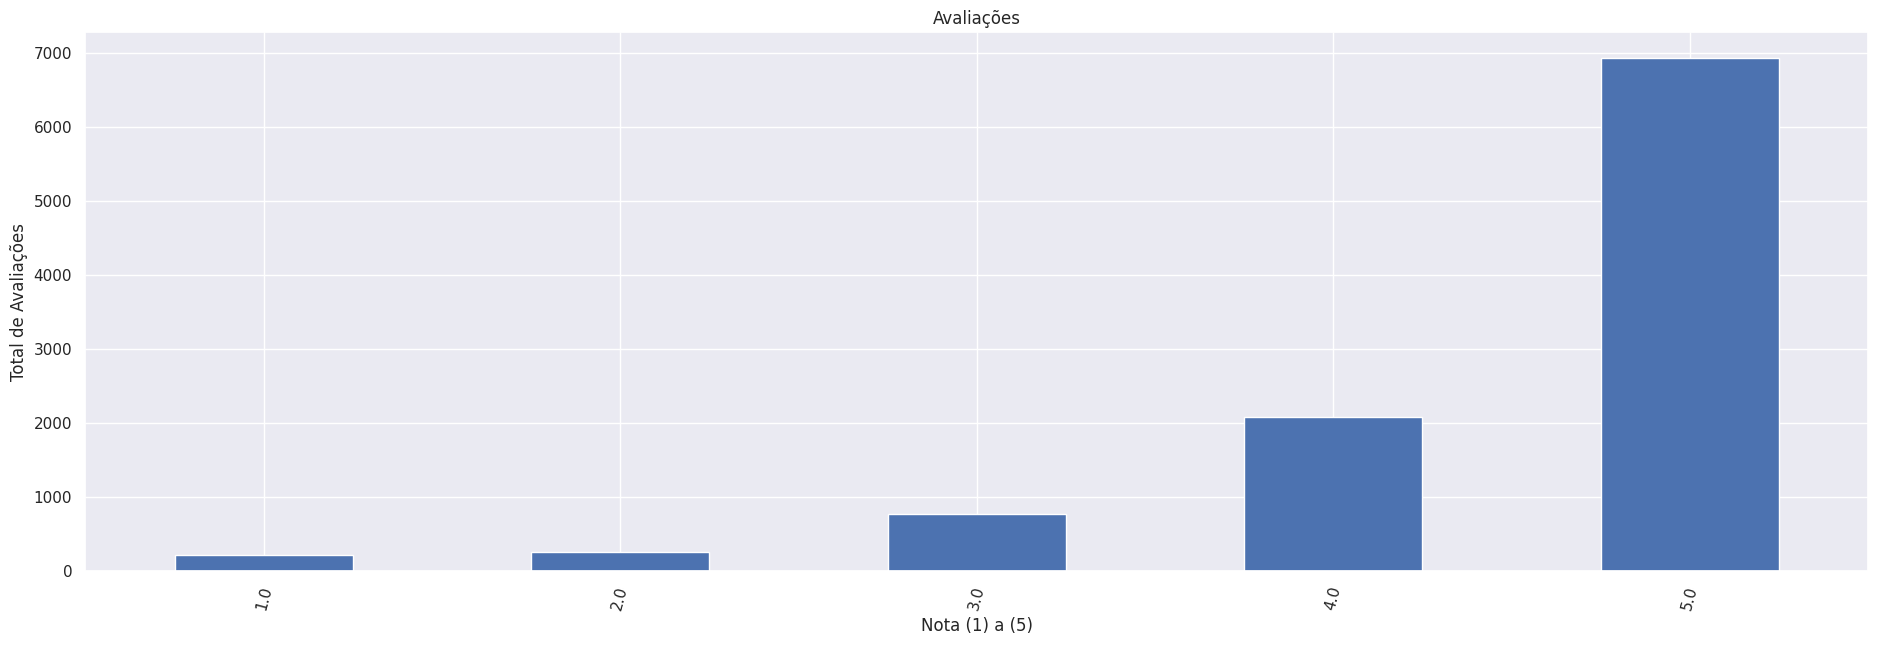

In [91]:
#df_all_outro.show()

#Plotagem
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Converter o merged_df para um dataframe do pandas
df_pandas = df_all_outro.toPandas()

# agrupar por marca e contar a quantidade de avaliações
grouped_df = df_pandas.groupby('overall')['Quantity'].sum()

# gerar o gráfico de barras
grouped_df.plot(kind='bar', rot=75, figsize=(23,7), title='Avaliações')

# definir os rótulos dos eixos
plt.xlabel('Nota (1) a (5)')
plt.ylabel('Total de Avaliações')

# exibir o gráfico
plt.show()


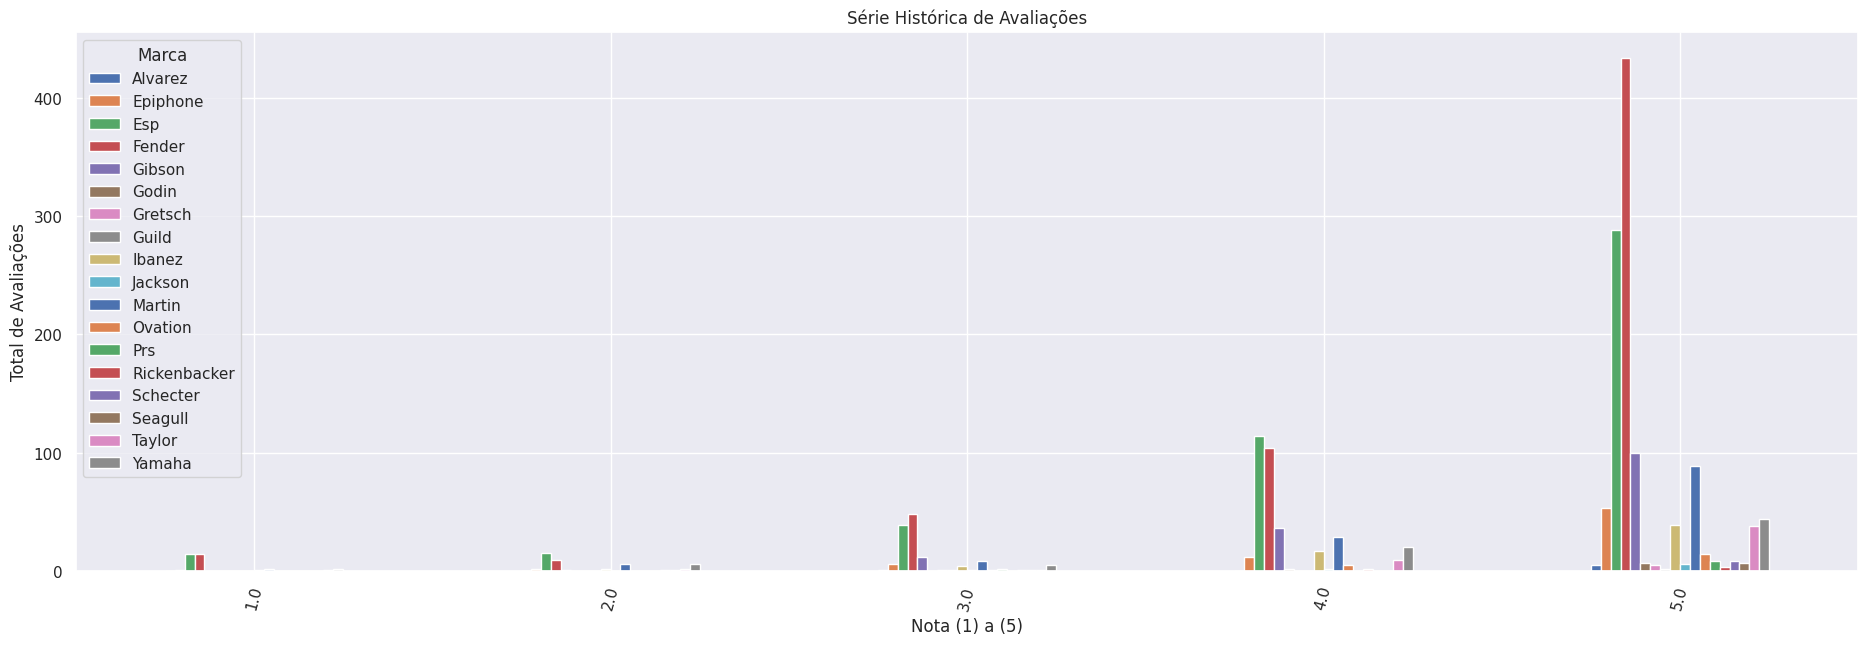

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Converter o merged_df para um dataframe do pandas
df_pandas = df_all_sem_outro.toPandas()

# agrupar por marca e contar a quantidade de avaliações
df_pandas.pivot_table(index='overall', columns='Marca', values='Quantity').plot(kind='bar', stacked=False, rot=75, figsize=(23,7), 
                title='Série Histórica de Avaliações')

# definir os rótulos dos eixos
plt.xlabel('Nota (1) a (5)')
plt.ylabel('Total de Avaliações')

# exibir o gráfico
plt.show()

# Nuvem de Palavras

In [94]:
from pyspark.sql.functions import regexp_replace, lower, split, explode, count

In [93]:
parquet_df_1.show(4)

+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------------+----------+----------+-----------+-----+
| ProductID| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|     reviewDateTime|reviewDate|reviewYear|reviewMonth|Marca|
+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------------+----------+----------+-----------+-----+
|1384719342|  [0, 0]|    5.0|Not much to write...|02 28, 2014|A2IBPI20UZIR0U|cassandra tu "Yea...|                good|    1393545600|2014-02-28 00:00:00|2014-02-28|      2014|    2014-02|  Esp|
|1384719342|[13, 14]|    5.0|The product does ...|03 16, 2013|A14VAT5EAX3D9S|                Jake|                Jake|    1363392000|2013-03-16 00:00:00|2013-03-16|      2013|    2013-03|Outro|
|1384719342|  [1, 1]|    

# Nuvem de Palavras

In [95]:
# Criar um dataframe com a coluna "reviewText"
df_nota5 = parquet_df_1.filter(parquet_df_1.overall == 5).select("reviewText")

# Remover caracteres especiais e transformar em minúsculas
df_nota5 = df_nota5.withColumn("clean_text", regexp_replace(df_nota5["reviewText"], "[^a-zA-Z0-9\\s]", ""))
df_nota5 = df_nota5.withColumn("clean_text", lower(df_nota5["clean_text"]))

# Dividir o texto em palavras
df_nota5 = df_nota5.withColumn("words", split(df_nota5["clean_text"], "\\s+"))

# Transformar cada linha com várias palavras em várias linhas com uma única palavra
df_nota5 = df_nota5.select(explode(df_nota5["words"]).alias("word"))

# Contar a frequência de cada palavra
word_counts_5 = df_nota5.groupBy("word").agg(count("*").alias("count"))

# Ordenar o resultado em ordem decrescente de frequência
word_counts_5 = word_counts_5.orderBy("count", ascending=False)

# Exibir as 10 palavras mais frequentes
word_counts_5.show(10)


+----+-----+
|word|count|
+----+-----+
| the|26929|
| and|17897|
|   a|17281|
|   i|16984|
|  to|14266|
|  it|12318|
|  is| 9127|
|  of| 8505|
| for| 8391|
|this| 8290|
+----+-----+
only showing top 10 rows



# Retirar artigos, preposições e palavras específicas

In [53]:
# Criar uma lista de palavras a serem removidas
retirar = ["i", "the", "a", "and", "to", "it", "is", "of", "for", "this", "in", "that", "with", "but", "was", "on", "my", "have", "had", "not", "at", "you", "are", "be", "as", "so", "if", "they", "can", "an", "or", "just", "like", "one", "out", "all", "about", "up", "there", "when", "from", "been", "would", "who", "which", "some", "more", "me", "its", "very", "dont", "than", "only", "do", "did", "could", "am", "no", "other", "her", "his", "he", "she", "we", "they", "them", "their", "our", "us", "because", "any", "will", "should", "must", "hadnt", "has", "have", "having", "how", "what", "where", "why", "when", "who", "whom", "which", "whose"]

# Aplicar o filtro para remover as palavras da lista "retirar"
word_counts_5 = word_counts_5.filter(~word_counts_5.word.isin(retirar))

# Ordenar o resultado em ordem decrescente de frequência
word_counts_5 = word_counts_5.orderBy("count", ascending=False)

# Exibir as 10 palavras mais frequentes
word_counts_5.show(10)

+-------+-----+
|   word|count|
+-------+-----+
| guitar| 3712|
|  great| 3042|
|  these| 2993|
|    use| 2350|
|  sound| 2341|
|strings| 2270|
|   good| 2210|
|   your| 2016|
|   well| 2012|
|  pedal| 1582|
+-------+-----+
only showing top 10 rows



# Nuvem de Palavras (Nota 5)

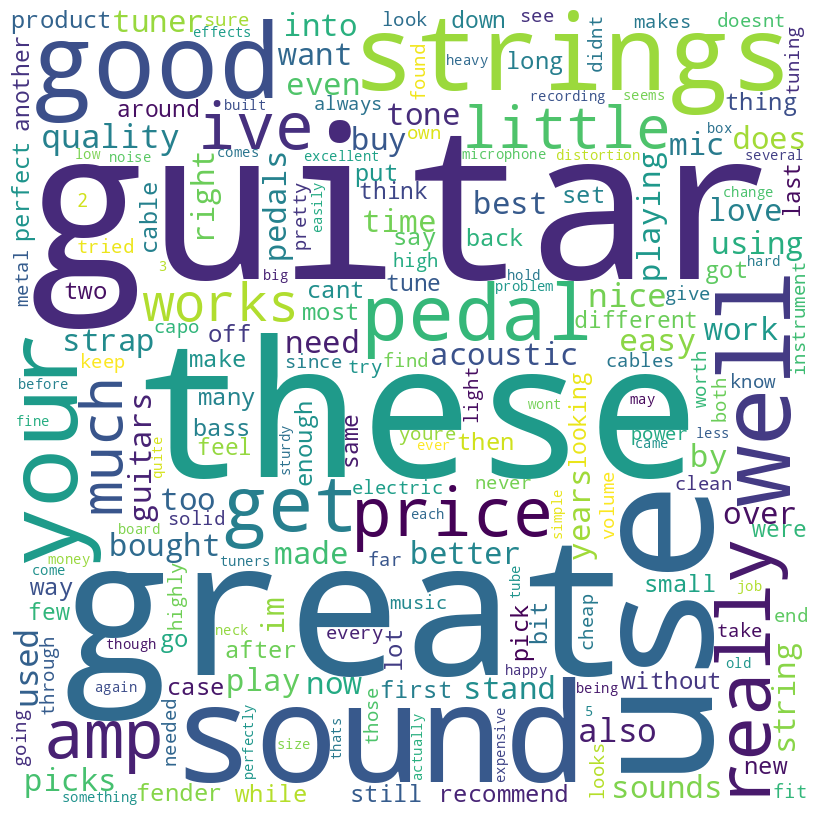

In [54]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Transforme o dataframe em um pandas dataframe
word_counts_pd = word_counts_5.toPandas()

# Crie um dicionário a partir do pandas dataframe
word_dict = dict(zip(word_counts_pd['word'], word_counts_pd['count']))

# Crie a nuvem de palavras
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = retirar, 
                min_font_size = 10).generate_from_frequencies(word_dict) 

# Plote a nuvem de palavras
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

# Nuvem de Palavras (Nota 1)

In [96]:
#Piores notas e avaliacoes
df = parquet_df_1.filter(parquet_df_1.overall == 1).select("reviewText")

# Remover caracteres especiais e transformar em minúsculas
df = df.withColumn("clean_text", regexp_replace(df["reviewText"], "[^a-zA-Z0-9\\s]", ""))
df = df.withColumn("clean_text", lower(df["clean_text"]))

# Dividir o texto em palavras
df = df.withColumn("words", split(df["clean_text"], "\\s+"))

# Transformar cada linha com várias palavras em várias linhas com uma única palavra
df = df.select(explode(df["words"]).alias("word"))

# Contar a frequência de cada palavra
word_counts = df.groupBy("word").agg(count("*").alias("count"))

# Criar uma lista de palavras a serem removidas
retirar = ["i", "the", "a", "and", "to", "it", "is", "of", "for", "this", "in", "that", "with", "but", "was", "on", "my", "have", "had", "not", "at", "you", "are", "be", "as", "so", "if", "they", "can", "an", "or", "just", "like", "one", "out", "all", "about", "up", "there", "when", "from", "been", "would", "who", "which", "some", "more", "me", "its", "very", "dont", "than", "only", "do", "did", "could", "am", "no", "other", "her", "his", "he", "she", "we", "they", "them", "their", "our", "us", "because", "any", "will", "should", "must", "hadnt", "has", "have", "having", "how", "what", "where", "why", "when", "who", "whom", "which", "whose"]

# Aplicar o filtro para remover as palavras da lista "retirar"
word_counts = word_counts.filter(~word_counts.word.isin(retirar))

# Ordenar o resultado em ordem decrescente de frequência
word_counts = word_counts.orderBy("count", ascending=False)

# Exibir as 10 palavras mais frequentes
word_counts.show(10)

+------+-----+
|  word|count|
+------+-----+
|guitar|   97|
| these|   84|
|   get|   78|
|   use|   65|
|  back|   61|
| sound|   61|
|  your|   59|
|really|   55|
|   buy|   54|
|  good|   53|
+------+-----+
only showing top 10 rows



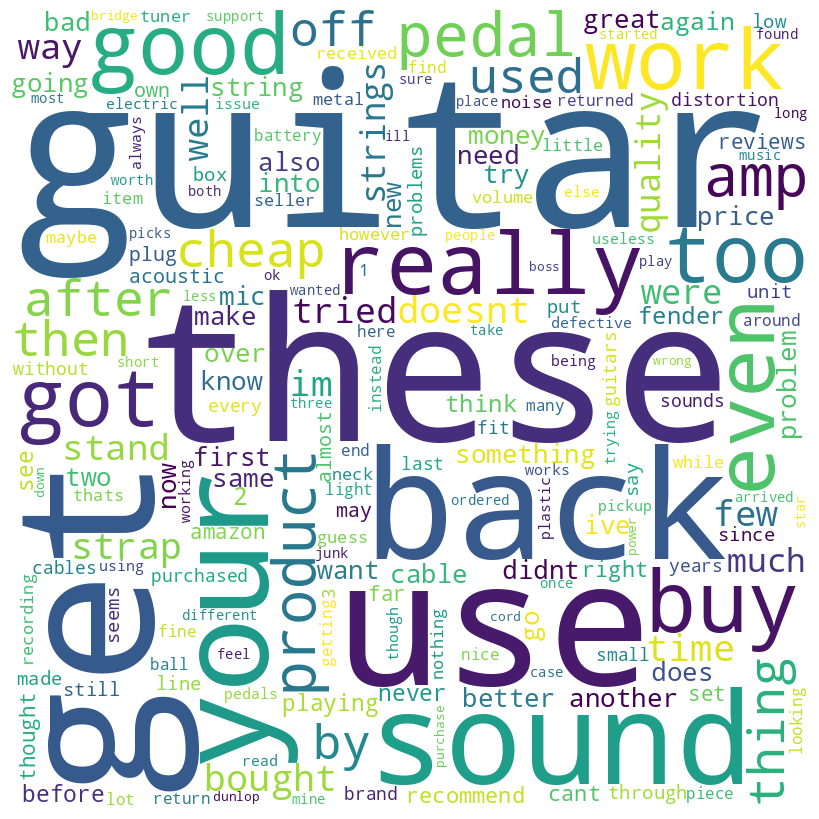

In [97]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Transforme o dataframe em um pandas dataframe
word_counts_pd = word_counts.toPandas()

# Crie um dicionário a partir do pandas dataframe
word_dict = dict(zip(word_counts_pd['word'], word_counts_pd['count']))

# Crie a nuvem de palavras
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = retirar, 
                min_font_size = 10).generate_from_frequencies(word_dict) 

# Plote a nuvem de palavras
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 